In [1]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import networkx as nx 
import numpy as np
import pandas as pd
import textwrap
import umap

from collections import Counter
from IPython.display import IFrame, Image, display
from matplotlib.axes import Axes
from matplotlib.figure import Figure
from networkx.algorithms.community import louvain_communities
from networkx.algorithms.community.quality import modularity
from sklearn.metrics.pairwise import cosine_similarity
from tqdm.notebook import tqdm

In [2]:
%load_ext autoreload
%autoreload 2

# Módulos nuestros
import conjunto_de_datos as cdd
import funciones_auxiliares as fa

1. Procesando regiones, subregiones y códigos de países...
Operación finalizada.
2. Procesando ubicaciones...
Operación finalizada.
3. Procesando datos de población...
Operación finalizada.
4. Procesando datos migratorios...
Operación finalizada.
5. Integrando los datos...
Operación finalizada.

Datos disponibles
-----------------
• df_m49: códigos y clasificaciones de países, e indicadores estructurales.
• df_poblaciones: población por país en los años con datos migratorios.
• df_coordenadas: centroides geográficos de cada país.
• df_migras_original: datos migratorios en bruto.
• df_migraciones: datos migratorios de 202 países.
• df_migras_90_24: reúne los datos anteriores.


**Comentario temporal**: todo lo que es visualizaciones lo saqué a un módulo como funciones auxiliares, para no sobrecargar el cuaderno y poder centrarnos en cómo se van desarrollando los temas, sin tanto código. La celdas con operaciones en las que se generan datos creo que está bueno que permanezcan en el cuaderno, más accesibles.

# **Tabla de referencias: códigos de países, regiones y subregiones**

La siguiente celda exporta a la carpeta `recursos` una tabla como imagen que ayuda a identificar un poco más rápido a cada país.

In [3]:
fa.crear_tabla_de_referencias(cdd.df_migraciones, cdd.df_m49)

# **Similitud relativa en redes migratorias**

Desde un enfoque observacional, analizamos los datos para intentar identificar grupos de países que resulten similares cuando se estudia hacia dónde emigraron sus poblaciones, en un año específico y también a lo largo de todo el período. Entre países, la diferencia de escala poblacional puede ser enorme en algunos casos: el $1\%$ de los migrantes de India o China es varios órdenes de magnitud mayor que el $1\%$ de los migrantes de los países con menos habitantes. Por este motivo, utilizamos una métrica no sensible a magnitudes absolutas para calcular la similitud relativa (SR). Distintas métricas capturan diferentes aspectos del fenómeno. En esta sección utilizamos la **similitud coseno**.


## **Proceso**

1. Para esta tarea, proponemos un **criterio de filtración** sobre el conjunto de datos en función de la **concentración de la emigración**, que permite reducir el ruido y conservar, para todos los paises, sus principales destinos migratorios (los que explican el 90% de sus datos).
2. Para cada año, construimos una matriz entre países donde cada fila corresponde a un país de origen, cada columna a un país destino y cada entrada al número de emigrantes que se encuentran en el país destino, provenientes del país origen. Sobre esta matriz calculamos la similitud relativa (coseno) entre países.  
3. Para cada año, construimos una red no dirigida con todos los países como nodos. Cada país, como origen, está vinculado a sus principales destinos. Pero además, si el país es relevante como destino de otro país origen, el vínculo (pesado con la similitud relativa entre ambos) también existe en la red.
4. Detectamos comunidades iterativamente en estas redes con el método de Louvain variando los parámetros, para comprobar la resistencia y persistencia de las comunidades detectadas dentro del rango de parámetros.
5. Identificamos grupos de países que, sin importar la resolución o la semilla con la que se configura el algoritmo, muestran coocurrencia perfecta en las comunidades detectadas, en un determinado año. A los países que en un año mantuvieron coocurrencia perfecta en las mismas comuniddaes, los llamamos **grupos de coocurrencia absoluta intermitente** *(GINT)*. A Los países que durante todo el período tuvieron coocurrencia perfecta, los llamamos **grupos de coocurrencia absoluta invariante** *(GINV)*.


Exigir coocurrencia absoluta **implica dejar fuera** de estas categorías, además de a aquellos países que efectivamente coincidieron muy poco, **a los países que en un determinado año tuvieron coocurrencia casi perfecta**. Por otro lado, la **relación de equivalencia** entre los miembros de los grupos intermitentes (por año) y de los grupos invariantes (a lo largo del período), permite utilizar a los últimos como *ejes* sobre los cuales ordenar las coocurrencias en comunidades detectadas y observar su evolución. Identificados estos grupos, exponemos un **gráfico de alta densidad para fines exploratorios**, que muestra la trayectoria de coocurrencias absolutas entre todos los países y permite identificar a aquellos que, aunque no formen parte de los *GINV*, han presentado coocurrencia casi perfecta o intermitente con distintos grupos de países a través del período, y los que no. Luego, sacrificando la dinámica pero ganando en  accesibilidad, calculamos la coocurrencia promedio de países en comunidades y exhibimos el resultado mediante una técnica de incrustación en el plano. Por último, incluimos un mapa que permite observar, para cada país, cuáles fueron sus principales comunidades de inmigrantes a lo largo del período.

### **Secuencia**

Criterio de filtración (90%) $\to$ Similitud relativa *(SR)* $\to$ Redes de similitud $\to$ Detección de comunidades *(semillas, resoluciones)* $\to$ Coocurrencia en comunidades $\to$ Coocurrencia absoluta intermitente *(GINT)* $\to$ Coocurrencia absoluta invariante *(GINV)* $\to$  Exposición de resultados.


### **Datos generados**

- `dicc_ppales_destinos_por_año: dict[int, dict[str, list[str]]]`: almacena las listas, en cada año y para cada país, de los destinos que explican dónde se encuentra el $90\%$ de su emigración.
- `dicc_simil_rel_por_año: dict[int, pd.DataFrame]`: almacena los df con las similitudes relativas calculadas en cada año.
- `dicc_grafo_sr_por_año: dict[int, nx.Graph]`: almacena los grafos por año con la similitud relativa como peso de las aristas.
- `dicc_cooc_sr_por_año: dict[int, pd.DataFrame]`: almacena las matrices de coocurrencia por año.
- `dicc_gint_sr_por_año: dict[int, list[set[str]]]`: almacena los **grupos de coorrurencia absoluta intermitente** por año.
- `dicc_ginv_sr: dict[int, set[str]]`: almacena los **grupos de coocurrencia absoluta invariante** del período.
- `dicc_comu_por_pais: dict[str, list[str]]`: contiene la **comunidad inmigrante más grande de cada país en cada año** del período, ordenadas de más antigua a más reciente.  

### **Aclaración**
**Para el cálculo de similitud no incluimos los datos migratorios sin origen conocido** contenidos en la categoría *Otros* (ZZ, ZZZ) ya que reducen la interpretabilidad del análisis al no poder explicar de dónde provienen realmente esas magnitudes que se acumulan en el stock migratorio. En esta primera parte de la sección, **la comparación entre países la realizamos sobre orígenes observables y ponemos el acento en el proceso de trabajo exploratorio y observacional, en su interpretabilidad y posibilidad de generalización**, no en la completitud del conjunto de datos ni en la prolijidad del sistema de registro y medición. En cambio, para la exposición de las principales comunidades de cada país o territorio sí los incluimos, por que en este contexto aporta información sobre la calidad de los datos del país en cuestión y permite dimensionar el peso relativo de esta categoría dentro de los datos originales.

## **Años y lista de países**

In [4]:
AÑOS: list[int] = cdd.df_migras_90_24.año.unique().tolist()
LISTA_PAISES: list[str] = cdd.df_migras_90_24.iso2_des.unique().tolist() # No contiene a otros 

## **Concentración de la emigración**

Los países concentran la mayor parte de su población emigrante en unos pocos destinos. El siguiente gráfico muestra cómo a través de los años, la mayoría de los países dirige el $90\%$ de su emigración a un conjunto pequeño de destinos, mientras que el 10% restante se distribuye en muchos otros países. En general, **superado el umbral del $90\%$** (con los datos ordenados según porcentaje acumulado de forma no ascendente), **lo que explica cada destino restante es a lo sumo $\sim 0.3\%$ o menos de la emigración del país considerado**. Si bien cada número representa historias de vidas, este criterio o filtro permite **reducir el ruido que producen muchos destinos con pocos migrantes**, y trabajar sobre la base de aquellos países que efectivamente explican la estructura o principales tendencias de la emigración.

### **Número de destinos que explican la emigración por país**

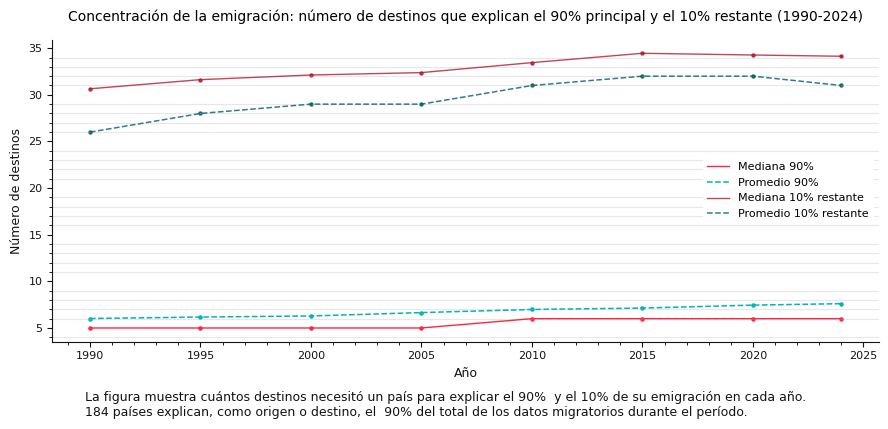

In [5]:
# Graficamos cuantos destinos concentran ~90% de los destinos migratorios 
# de la mayoría de países a través de los años
df_cant_destinos = cdd.df_migras_90_24[['iso2_orig', 'iso2_des', 'año', 'migrantes']]
df_cant_destinos = df_cant_destinos[df_cant_destinos.iso2_orig != 'ZZ'] # No incluimos orígenes desconocidos 
pct_explicacion = 91

# Listas para graficar
medianas: list[int | float] = []
promedios: list[int | float] = []
medianas_restantes: list[int | float] = []
promedios_restantes: list[int | float] = []

# Almacena los países que utilizaremos más adelante
# para estudiar la similitud
paises_que_explican: set[str] = set()

# Estructura donde almacenamos la lista de países ppales. de cada país 
# La usamos (opcionalmente) más adelante para construir los grafos
dicc_ppales_destinos_por_año: dict[int, dict[str, list[str]]] = {}
for año in df_cant_destinos.año.unique():
    # Recortamos al año actual
    df_año = df_cant_destinos[df_cant_destinos.año == año].reset_index(drop=True)
    
    cant_paises_que_explican: list[int] = []
    cant_restante: list[int] = []
    dicc_ppales_destinos_por_pais: dict[str, str] = {}
    for pais in df_año.iso2_orig.unique():
        # Calculamos la cantidad de países que componen ~ pct_explicacion de emigraciones 
        df_pais = (
            df_año[df_año.iso2_orig == pais]
            .reset_index(drop=True)
            .sort_values(['migrantes'], ascending=False)
        )
        total_migrantes_pais = df_pais['migrantes'].sum()
        df_pais['pct_emigrantes'] = df_pais['migrantes'] * 100 / total_migrantes_pais
        df_pais['pct_acumulado'] =  df_pais['pct_emigrantes'].cumsum()
        
        # Obtenemos la cantidad aproximada de países
        df_cumplen_pct = df_pais['pct_acumulado'] <= pct_explicacion
        # Sumamos el total que cumple e incluimos el siguiente 
        # para compensar los casos en que paíese quedan por arriba del umbral
        # pero el anterior está lejos de alcanzarlo
        total_cumplen = df_cumplen_pct.sum() + 1
        cant_paises_que_explican.append(total_cumplen)
        total_restante = len(df_pais) - total_cumplen
        cant_restante.append(total_restante)
        # Almacenamos la lista de países
        ppales_paises = df_pais.iloc[:total_cumplen, :].iso2_des.to_list()
        dicc_ppales_destinos_por_pais[pais] = df_pais.iloc[:total_cumplen, :].iso2_des.to_list()
        
        # Actualizamos el conjunto de países 
        paises_que_explican.update(ppales_paises)
    
    medianas.append(np.median(cant_paises_que_explican))
    promedios.append(np.mean(cant_paises_que_explican))    
    medianas_restantes.append(np.median(cant_restante))
    promedios_restantes.append(np.mean(cant_restante))

    # ALamcenamos los ppales. destinos por país
    dicc_ppales_destinos_por_año[año] = dicc_ppales_destinos_por_pais

vis = fa.graficar_concentracion_emigracion(   
    df_cant_destinos,
    paises_que_explican,
    medianas, 
    promedios, 
    medianas_restantes, 
    promedios_restantes        
)
display(vis[0])

## **Similitud relativa**

In [6]:
# Estructura que almacena los df con las similitudes calculadas en cada año
# La usamos más adelante para crear los grafos
dicc_simil_rel_por_año: dict[int, pd.DataFrame] = {}

for año in AÑOS:    
    # Recortamos a los datos de interés
    df_año = cdd.df_migras_90_24[cdd.df_migras_90_24.año == año]
    df_año = df_año[df_año.iso2_orig != 'ZZ'] # No incluimos orígenes desconocidos
    df_año = (
        df_año[['iso2_orig', 'iso2_des', 'año', 'migrantes']]
        .rename(columns={'migrantes': 'emigrantes'})
    )    
    # Creamos un df cuyas filas serán vectores para calcular similitud
    df_origen_a_destino = pd.DataFrame()
    for pais in LISTA_PAISES:
        # Nos quedamos con los datos de emigrantes del país
        df_emigraciones_del_pais = df_año[df_año.iso2_orig == pais]

        # Construimos un diccionario de la forma {país_destino: emigrantes}
        dicc_emigrantes_por_pais = dict(
            zip(df_emigraciones_del_pais['iso2_des'], df_emigraciones_del_pais['emigrantes'])
        )        
        emigrantes_por_destino = {
            destino: dicc_emigrantes_por_pais.get(destino, 0)
            for destino in LISTA_PAISES
        }
        fila = {'iso2_orig': pais, **emigrantes_por_destino}
        df_origen_a_destino = pd.concat([df_origen_a_destino, pd.DataFrame([fila])])

    # Creamos el df de similitud de perfiles migratorios y lo almacenamos en el diccionario  
    df_emigrantes_a_paises = df_origen_a_destino.set_index('iso2_orig')    
    matriz_similitud = cosine_similarity(df_emigrantes_a_paises.values) 
    df_similitudes = pd.DataFrame(
        matriz_similitud,
        index=df_emigrantes_a_paises.index,
        columns=df_emigrantes_a_paises.index
    )    
    dicc_simil_rel_por_año[año] = df_similitudes # Acceso al dato: dicc_simil_rel_por_año[año].loc[País_a, País_b]

## **Redes de similitud relativa**

In [7]:
# Estructura que almacena los grafos no dirigidos por año
# con la similitud relativa como peso de las aristas
dicc_grafo_sr_por_año: dict[int, nx.Graph] = {}
epsilon = 1e-9
for año in AÑOS:
    grafo_año = nx.Graph()
    for origen, destinos in dicc_ppales_destinos_por_año[año].items():
        for destino in destinos:                    
            similitud_relativa = dicc_simil_rel_por_año[año].loc[origen, destino]
            # Agregamos un epsilon para prevenir la división por cero al detectar comunidades
            grafo_año.add_edge(origen, destino, similitud_relativa=similitud_relativa + epsilon)
    dicc_grafo_sr_por_año[año] = grafo_año

## **Coocurrencia en comunidades**

Los resultados ya fueron calculos (tarda alrededor de 7 minutos). Se pueden volver a calcular y registrar si se identifica algún error, o levantarlos desde la celda que le sigue.

In [8]:
# # Construimos una matriz de coocurrencia por año
# # donde guardar los resultados de los distintos parámetros
# def coocurrencias(
#     años: list[int],
#     paises: list[str],
#     dicc_grafo_por_año: dict[int, nx.Graph], # Las redes pesadas con la simlitud (rel o abs)   
#     peso: str, # Definido como atributo de las aristas de los grafos en el dicc
#     barra: tqdm | None = None
# ) -> dict[int, pd.DataFrame]:

#     # Configuración inicial
#     SEMILLAS = [2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71]
#     RESOLUCIONES = [0.2, 0.3, 0.5, 0.7, 1.0, 1.3, 1.5, 1.7, 2.0, 2.3, 2.5, 2.7, 3.0]    
#     cant_iter_tot = len(SEMILLAS) * len(RESOLUCIONES) * len(años)
    
#     # Estructuras que almacenan las matrices de coocurrencia por año
#     # y los resultados obtenidos
#     dicc_cooc_por_año: dict[int, pd.DataFrame] = {}
#     resultados: list[dict[str, int | float]] = []
    
#     iteraciones = 0
#     for año in años:
#         df_coocurrencias = pd.DataFrame(
#             0,
#             index=paises,
#             columns=paises,
#             dtype=np.int32
#         )
#         for semilla in SEMILLAS:
#             for resolucion in RESOLUCIONES:
#                 iteraciones += 1
#                 # Detectamos las comunidades 
#                 comunidades = louvain_communities(
#                     dicc_grafo_por_año[año],
#                     weight=peso,
#                     seed=semilla,
#                     resolution=resolucion,
#                 )
#                 modularidad = modularity(
#                     dicc_grafo_por_año[año],
#                     comunidades,
#                     weight=peso,
#                     resolution=resolucion,
#                 )
#                 resultados.append(
#                     {
#                         'año': año,
#                         'semilla': semilla,
#                         'resolucion': resolucion,
#                         'modularidad': modularidad,
#                         'num_comunidades': len(comunidades),
#                     }
#                 )
#                 # Registramos la coocurrencias
#                 for comunidad in comunidades:
#                     for i in comunidad:
#                         for j in comunidad:
#                             # La matriz es simétrica, solo miramos el triángulo superior
#                             if i < j:
#                                 df_coocurrencias.loc[i, j] += 1                
#                 barra.n = (iteraciones * 100) / cant_iter_tot
#                 barra.refresh()
                
#         # Llevamos los valores a [0,1] para facilitar la interpretación 
#         df_coocurrencias /= (len(SEMILLAS) * len(RESOLUCIONES)) # Coocurrencias del año en curso
#         # Copiamos al triangulo inferior
#         df_coocurrencias += df_coocurrencias.T
#         # Llenamos la diagonal para no tener que agregar cada país a mano al buscar los grupos
#         np.fill_diagonal(df_coocurrencias.values, 1)
#         # Almacenamos la matriz obtenida
#         dicc_cooc_por_año[año] = df_coocurrencias

#     df_resultados = pd.DataFrame(resultados)
#     # Para actualizar al salir del ciclo
#     barra.n = (iteraciones * 100) / cant_iter_tot
#     barra.refresh()

#     return dicc_cooc_por_año, df_resultados

# paises = dicc_simil_rel_por_año[2024].columns
# pct_barra = 0.0
# formato_barra: str = "{desc}: [{bar}] {percentage:3.0f}% | {elapsed}"
# texto_barra: str = 'Construyendo las matrices de coocurrencia (SR)'          
# with tqdm(total=100, desc=texto_barra, bar_format=formato_barra) as barra_pct:
#     dicc_cooc_sr_por_año, df_resultados = coocurrencias(       
#         AÑOS,
#         paises,
#         dicc_grafo_sr_por_año,
#         'similitud_relativa', # Definido como atributo de las aristas de los grafos en el dicc
#         barra_pct
#     )  

# # Guardamos lo calculado
# for año in AÑOS:    
#     dicc_cooc_sr_por_año[año].to_csv(f'recursos/df_cooc_sr_{año}.csv') # Redes con los países principales
# df_resultados.to_csv('recursos/df_resultados_sr.csv')


Para **cargar resultados** desde la carpeta `recursos` $\downarrow$

In [9]:
# Para levantar los datos calculados 
dicc_cooc_sr_por_año = {}

for año in AÑOS:
    dicc_cooc_sr_por_año[año] = pd.read_csv(
        f'recursos/df_cooc_sr_{año}.csv', 
        index_col=0,
        keep_default_na=False
    )
df_resultados = pd.read_csv('recursos/df_resultados_sr.csv')

### **Comunidades y modularidad**

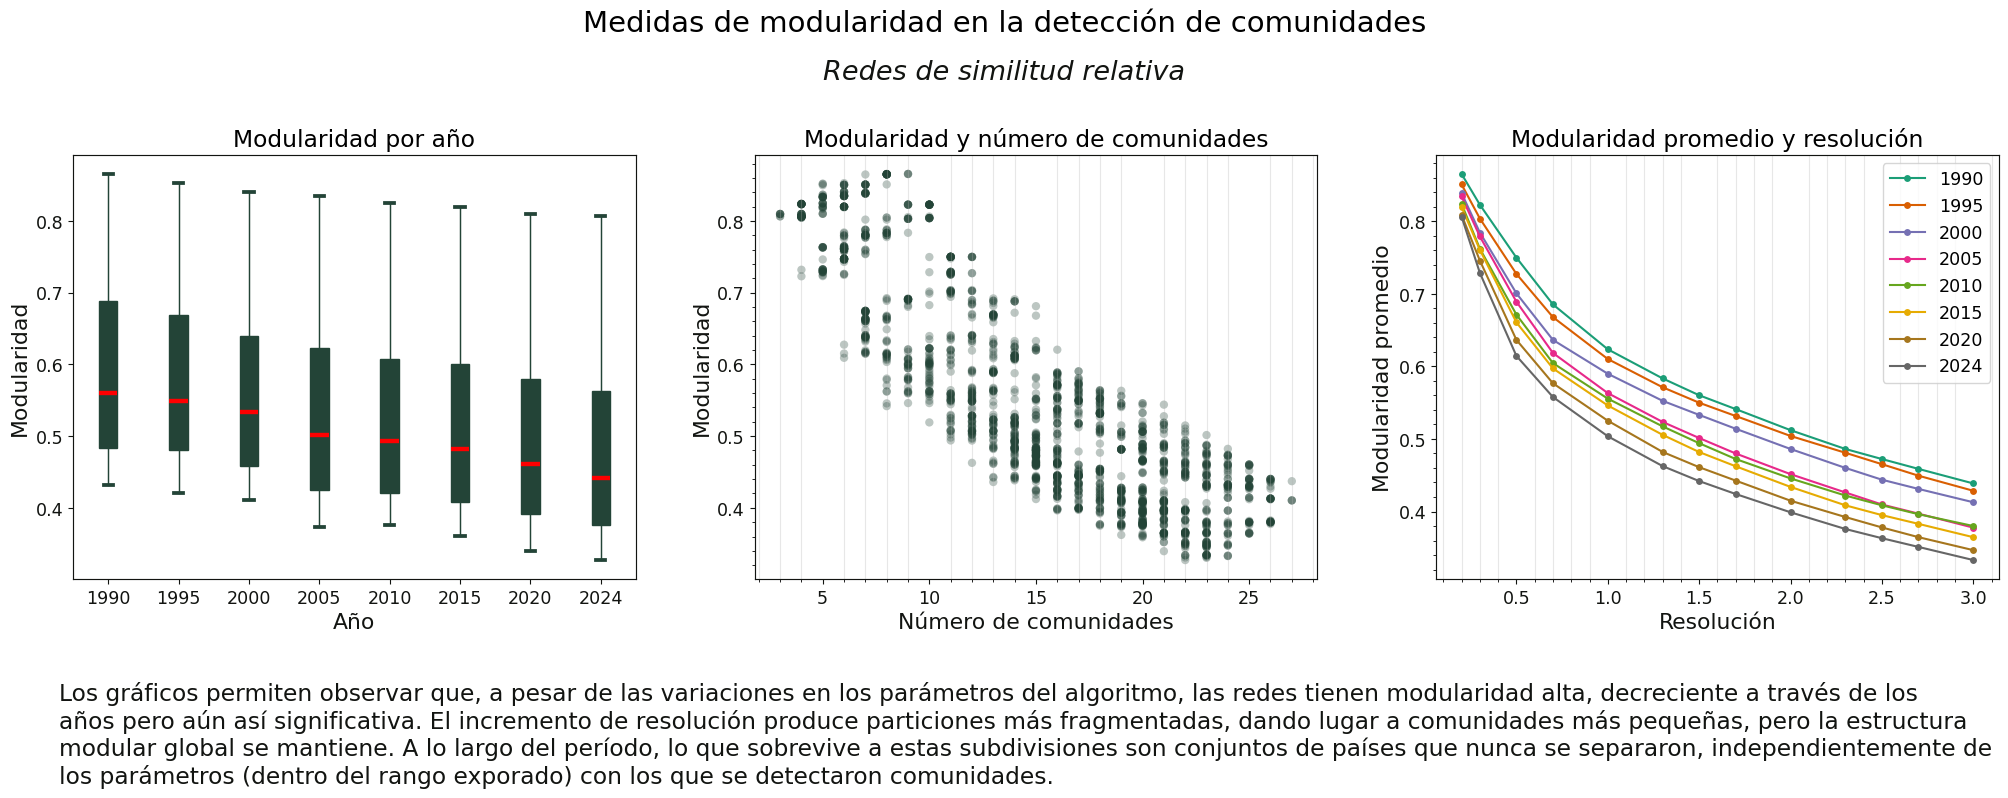

In [10]:
titulo = 'Medidas de modularidad en la detección de comunidades'
subtitulo = 'Redes de similitud relativa'
descripcion = ( # Completar
    'Los gráficos permiten observar que, a pesar de las variaciones en los parámetros del algoritmo, '
    'las redes tienen modularidad alta, decreciente a través de los años pero aún así significativa. '
    'El incremento de resolución produce particiones más fragmentadas, dando lugar a comunidades más pequeñas, '
    'pero la estructura modular global se mantiene. A lo largo del período, lo que sobrevive a estas subdivisiones ' 
    'son conjuntos de países que nunca se separaron, independientemente de los parámetros (dentro del rango exporado) '
    'con los que se detectaron comunidades.'    
)

nombre_salida = 'modularidad'

vis = fa.graficar_resultados(
    df_resultados,
    titulo,
    subtitulo,
    descripcion,
    160, # Caracters por línea
    nombre_salida,
)
display(vis)

### **Distribución de la coocurrencia**

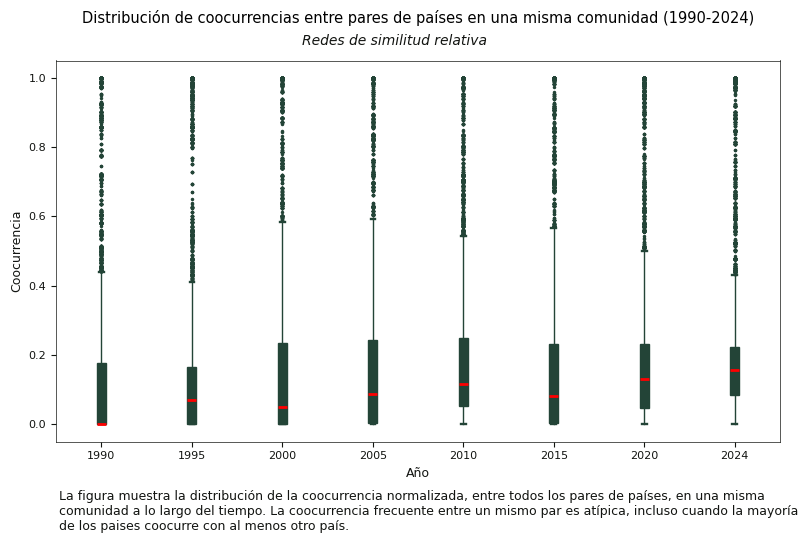

In [11]:
titulo = 'Distribución de coocurrencias entre pares de países en una misma comunidad (1990-2024)'
subtitulo = 'Redes de similitud relativa'
descripcion = (
    'La figura muestra la distribución de la coocurrencia normalizada, entre todos los pares de países, '
    'en una misma comunidad a lo largo del tiempo. La coocurrencia frecuente entre un mismo par es atípica, '
    'incluso cuando la mayoría de los paises coocurre con al menos otro país.'
)
nombre_salida = 'distribucion_de_coocurrencias_sr_por_año'


vis = fa.graficar_distribucion_coocurrencia(
    AÑOS, 
    dicc_cooc_sr_por_año,
    titulo,
    subtitulo,
    descripcion,
    nombre_salida
)
display(vis[0])

## **Coocurrencia absoluta intermitente (GINT)**

In [25]:
# Encontramos los GINT-SR de cada año
def extraer_gint(
    años: list[int],
    dicc_cooc_por_año: dict[int, pd.DataFrame],
) -> tuple[
    dict[int, list[set[str]]],
    dict[int, int | float],
    dict[int, int | float]
]:
    dicc_gint_por_año: dict[int, list[set[str]]] = {}    
    dicc_promedio_miembros_gint_en_año: dict[int, int] = {}
    dicc_mediana_miembros_gint_en_año: dict[int, int] = {}
    for año in años:
        df_año = dicc_cooc_por_año[año]
        grupos = []
        incluidos = set()
        for pais in df_año.columns:
            if pais in incluidos:
                continue
            gint_pais = set(df_año.index[df_año[pais] == 1.0]) # Exigimos coocurrencia absoluta
            if len(gint_pais) == 1:
                # Cuando solo encuentra un 1 en la diagonal
                continue
            grupos.append(gint_pais)
            incluidos |= gint_pais
        dicc_gint_por_año[año] = grupos
        
        # Almacenamos el promedio de miembros y tambien la mediana para comparar
        lista_cant_miembros = [len(grupo) for grupo in grupos]
        
        promedio_miembros_gint_año = int(np.ceil(np.mean(lista_cant_miembros)))
        dicc_promedio_miembros_gint_en_año[año] = promedio_miembros_gint_año
        
        mediana_miembros_gint_año = int(np.ceil(np.median(lista_cant_miembros)))
        dicc_mediana_miembros_gint_en_año[año] = mediana_miembros_gint_año

    return (
        dicc_gint_por_año, 
        dicc_promedio_miembros_gint_en_año,
        dicc_mediana_miembros_gint_en_año        
    )

dicc_gint_sr_por_año, dicc_prom_miembros_gintsr, dicc_med_miembros_gintsr = (
    extraer_gint(AÑOS, dicc_cooc_sr_por_año)
)

# Imprimimos el resultado
titulo = 'Grupos de coocurrencia absoluta intermitente (GINT)'
lineas = f'\n{'-' * len(titulo)}\n'
encabezado = lineas + titulo + lineas

# Obtenemos el texto de cada año
texto_año = {} 
for año, gints in dicc_gint_sr_por_año.items():      
    tex_año = ''
    gints_ordenados = sorted(gints, key=len, reverse=True)
    i = 1
    for gint in gints_ordenados:
        cadena_gint = str(gint).replace("'", "")[1:-1]
        tex_linea = f'{' ' * 2}{i}. ' + cadena_gint + '.\n'
        tex_año += tex_linea
        i += 1
    texto_año[año] = tex_año

print(encabezado)
for año, gints in texto_año.items():
    print(f'{año}\n')
    print(gints)



---------------------------------------------------
Grupos de coocurrencia absoluta intermitente (GINT)
---------------------------------------------------

1990

  1. FI, KZ, KP, EE, GE, AZ, TJ, AM, LV, TM, KG, MN, RU, UZ, LT, UA, BY, MD.
  2. KW, SA, PK, AE, PS, JO, EG, OM, YE, LK, BD, SD, BH, QA, SY, MM.
  3. ML, MR, BJ, BF, NG, TG, NE, CI, GH.
  4. BG, AT, SK, CZ, RO, HU, TR.
  5. SI, ME, AL, HR, RS, BA, MK.
  6. HN, CR, SV, GT, BZ, MX, NI.
  7. KI, FJ, SB, NR, PG, TV, VU.
  8. GN, GW, LR, SL, GM, SN.
  9. ZA, LS, NL, SR, SZ, GB.
  10. MU, SM, MC, SC, IT, TN.
  11. NA, BW, ZW, MW, MZ, ZM.
  12. MO, JP, CN, HK, KR, PH.
  13. AD, CU, UY, ES, PT.
  14. MV, WS, FK, IE, AU.
  15. GD, VC, LC, AG, BB.
  16. UG, CD, BI, TZ, RW.
  17. DK, NO, SE, IS.
  18. DZ, LY, EH, CH.
  19. ID, MY, TL, SG.
  20. CG, CM, GQ, GA.
  21. MA, LU, BE.
  22. BR, PY, AR.
  23. DM, BS, KN.
  24. ET, SS, ER.
  25. ST, AO, CV.
  26. BN, TW, TH.
  27. MH, FM, PW.
  28. PL, GR.
  29. CL, BO.
  30. CA, LA.
  31. IR,

### **Países sin coocurrencia absoluta intermitente**

En esta lista están los paises que en todos los años del período, nunca mantuvieron coocurrencia perfecta con otros paísese.

In [26]:
paises_en_gint = set()
for año in dicc_gint_sr_por_año.keys():
    gints_del_año = dicc_gint_sr_por_año[año]
    for gint in gints_del_año:
        paises_en_gint = paises_en_gint | gint
paises_sin_gint = set(LISTA_PAISES) - paises_en_gint
print(paises_sin_gint)

{'JM', 'LB', 'DE', 'IL'}


## **Coocurrencia absoluta invariante (GINV)**

In [28]:
# Encontramos los invariantes durante el período.
def extraer_ginv(
    años: list[int],
    dicc_cooc_por_año: dict[int, pd.DataFrame],    
) -> dict[int, set[str]]:
    # Construimos un df que indica cuales de sus entradas fueron siempre 1 
    # (qué par de países mantuvieron coocurrencia perfecta durante todo el periodo)
    filtro = np.ones_like(dicc_cooc_por_año[1990], dtype=bool)
    for año in AÑOS:
        filtro &= (dicc_cooc_por_año[año] == 1.0)
    df_invariantes = filtro.astype(float)
    
    dicc_ginv: dict[int, set[str]] = {}
    incluidos = set()   
    i = 0
    for pais in df_invariantes.columns:
        if pais in incluidos:
            continue
        invar_pais = set(df_invariantes.index[df_invariantes[pais] == 1.0])
        if len(invar_pais) == 1:
            # Cuando solo encuentra un 1 en la diagonal
            continue
        incluidos |= invar_pais
        dicc_ginv[i] = invar_pais
        i+=1
    
    return dicc_ginv



def ordenar_por_subregion_principal(dicc_ginv) -> dict[int, set[str]]:
    """
    Ordena los grupos de invariantes encontradros en función de la subregion
    de la mayoria de sus miembros.
    """    
    df_paises_y_subregiones = (
        cdd.df_m49[['iso2_m49', 'subregion_ES']]
        .rename(columns={'iso2_m49': 'cod_alfa2', 'subregion_ES': 'subregion'})
    )
    dicc_subregiones = {}
    for nro, miembros in dicc_ginv.items():
        subregiones = []
        for miembro in miembros:
            subregiones.append(
                df_paises_y_subregiones.loc[
                    df_paises_y_subregiones.cod_alfa2 == miembro, 'subregion'
                    ].iloc[0]
            )
        subreg_mayoritaria = Counter(subregiones).most_common(1)[0][0]
        dicc_subregiones[nro] = subreg_mayoritaria
    lista_ordenada_subregiones = sorted(dicc_subregiones.items(), key=lambda x: x[1])
    res = {}
    i = 0
    for (indice_invar, _) in lista_ordenada_subregiones:
        miembros_invar = dicc_ginv[indice_invar]
        i += len(miembros_invar) - 1        
        res[i] = miembros_invar
        i+=1
    return res 


def separar_claves(dicc):
    """
    Distribuye las claves espaciando entre ínidices en función de la cantidad
    de miembros del grupo invariante, para facilitar la diagramación posterior.
    """
    res = {}
    pos = 0  
    for clave in sorted(dicc):
        valores = dicc[clave]
        n = len(valores)
        ancho = n if n % 2 == 1 else n + 1
        nueva_clave = pos + ancho // 2
        res[nueva_clave] = valores
        pos += ancho
    return res


# Obtenemos los invariantes
dicc_ginv_sr = extraer_ginv(AÑOS, dicc_cooc_sr_por_año)
dicc_ginv_sr = ordenar_por_subregion_principal(dicc_ginv_sr)
dicc_ginv_sr = separar_claves(dicc_ginv_sr)

# Imprimimos el resultado
titulo = 'Grupos de coocurrencia absoluta invariante (GINV)'
lineas = f'\n{'-' * len(titulo)}\n'
encabezado = lineas + titulo + lineas
texto = '\n'
aclaracion = (
    '\nLa lista muestra los grupos de países que tuvieron coocurrencia '
    'absoluta perfecta durante el período.\n'
)
i = 1
for invariante in sorted(dicc_ginv_sr.values(), key=len, reverse=True):
    cadena_invar = str(invariante).replace("'", "")[1:-1]
    texto += f'{i}. {cadena_invar}. \n'
    i += 1
print(encabezado, texto, aclaracion)


-------------------------------------------------
Grupos de coocurrencia absoluta invariante (GINV)
-------------------------------------------------
 
1. KZ, EE, GE, TJ, AM, LV, TM, KG, MN, RU, UZ, AZ, UA, BY. 
2. KW, SA, PK, AE, JO, BH, QA. 
3. SI, ME, HR, RS, BA. 
4. ZW, BW, MW, MZ, ZM. 
5. UG, CD, BI, TZ, RW. 
6. FJ, TV, NR, KI. 
7. LC, BB, VC. 
8. IT, MU, SM. 
9. DK, NO, IS. 
10. BF, ML, CI. 
11. TG, BJ, NE. 
12. MX, GT. 
13. DM, KN. 
14. NP, BT. 
15. MO, CN. 
16. KR, JP. 
17. ID, SG. 
18. TH, TW. 
19. VN, KH. 
20. AL, MK. 
21. ES, AD. 
22. CZ, AT. 
23. VU, PG. 
24. FM, PW. 
25. GN, SL. 
26. ZA, LS. 
27. CM, GA. 
28. ST, AO. 
29. MG, KM. 
30. DJ, SO. 
31. DZ, EH. 
 
La lista muestra los grupos de países que tuvieron coocurrencia absoluta perfecta durante el período.



## **Gráfico de exploración: coocurrencia absoluta intermitente e invariante**

Utilizamos su continuidad para definir **segmentos de referencia** que atraviesan todo el período. El resto de países pueden unirse o separarse de estos grupos. 
Encontramos los invariantes cuyo clave de del diccionario la transformamos en una coordenada en y, que funcionará como segmento de referencia (SDR) en el diagrama


Construyendo diagrama de trayectorias: [          ]   0% | 00:00

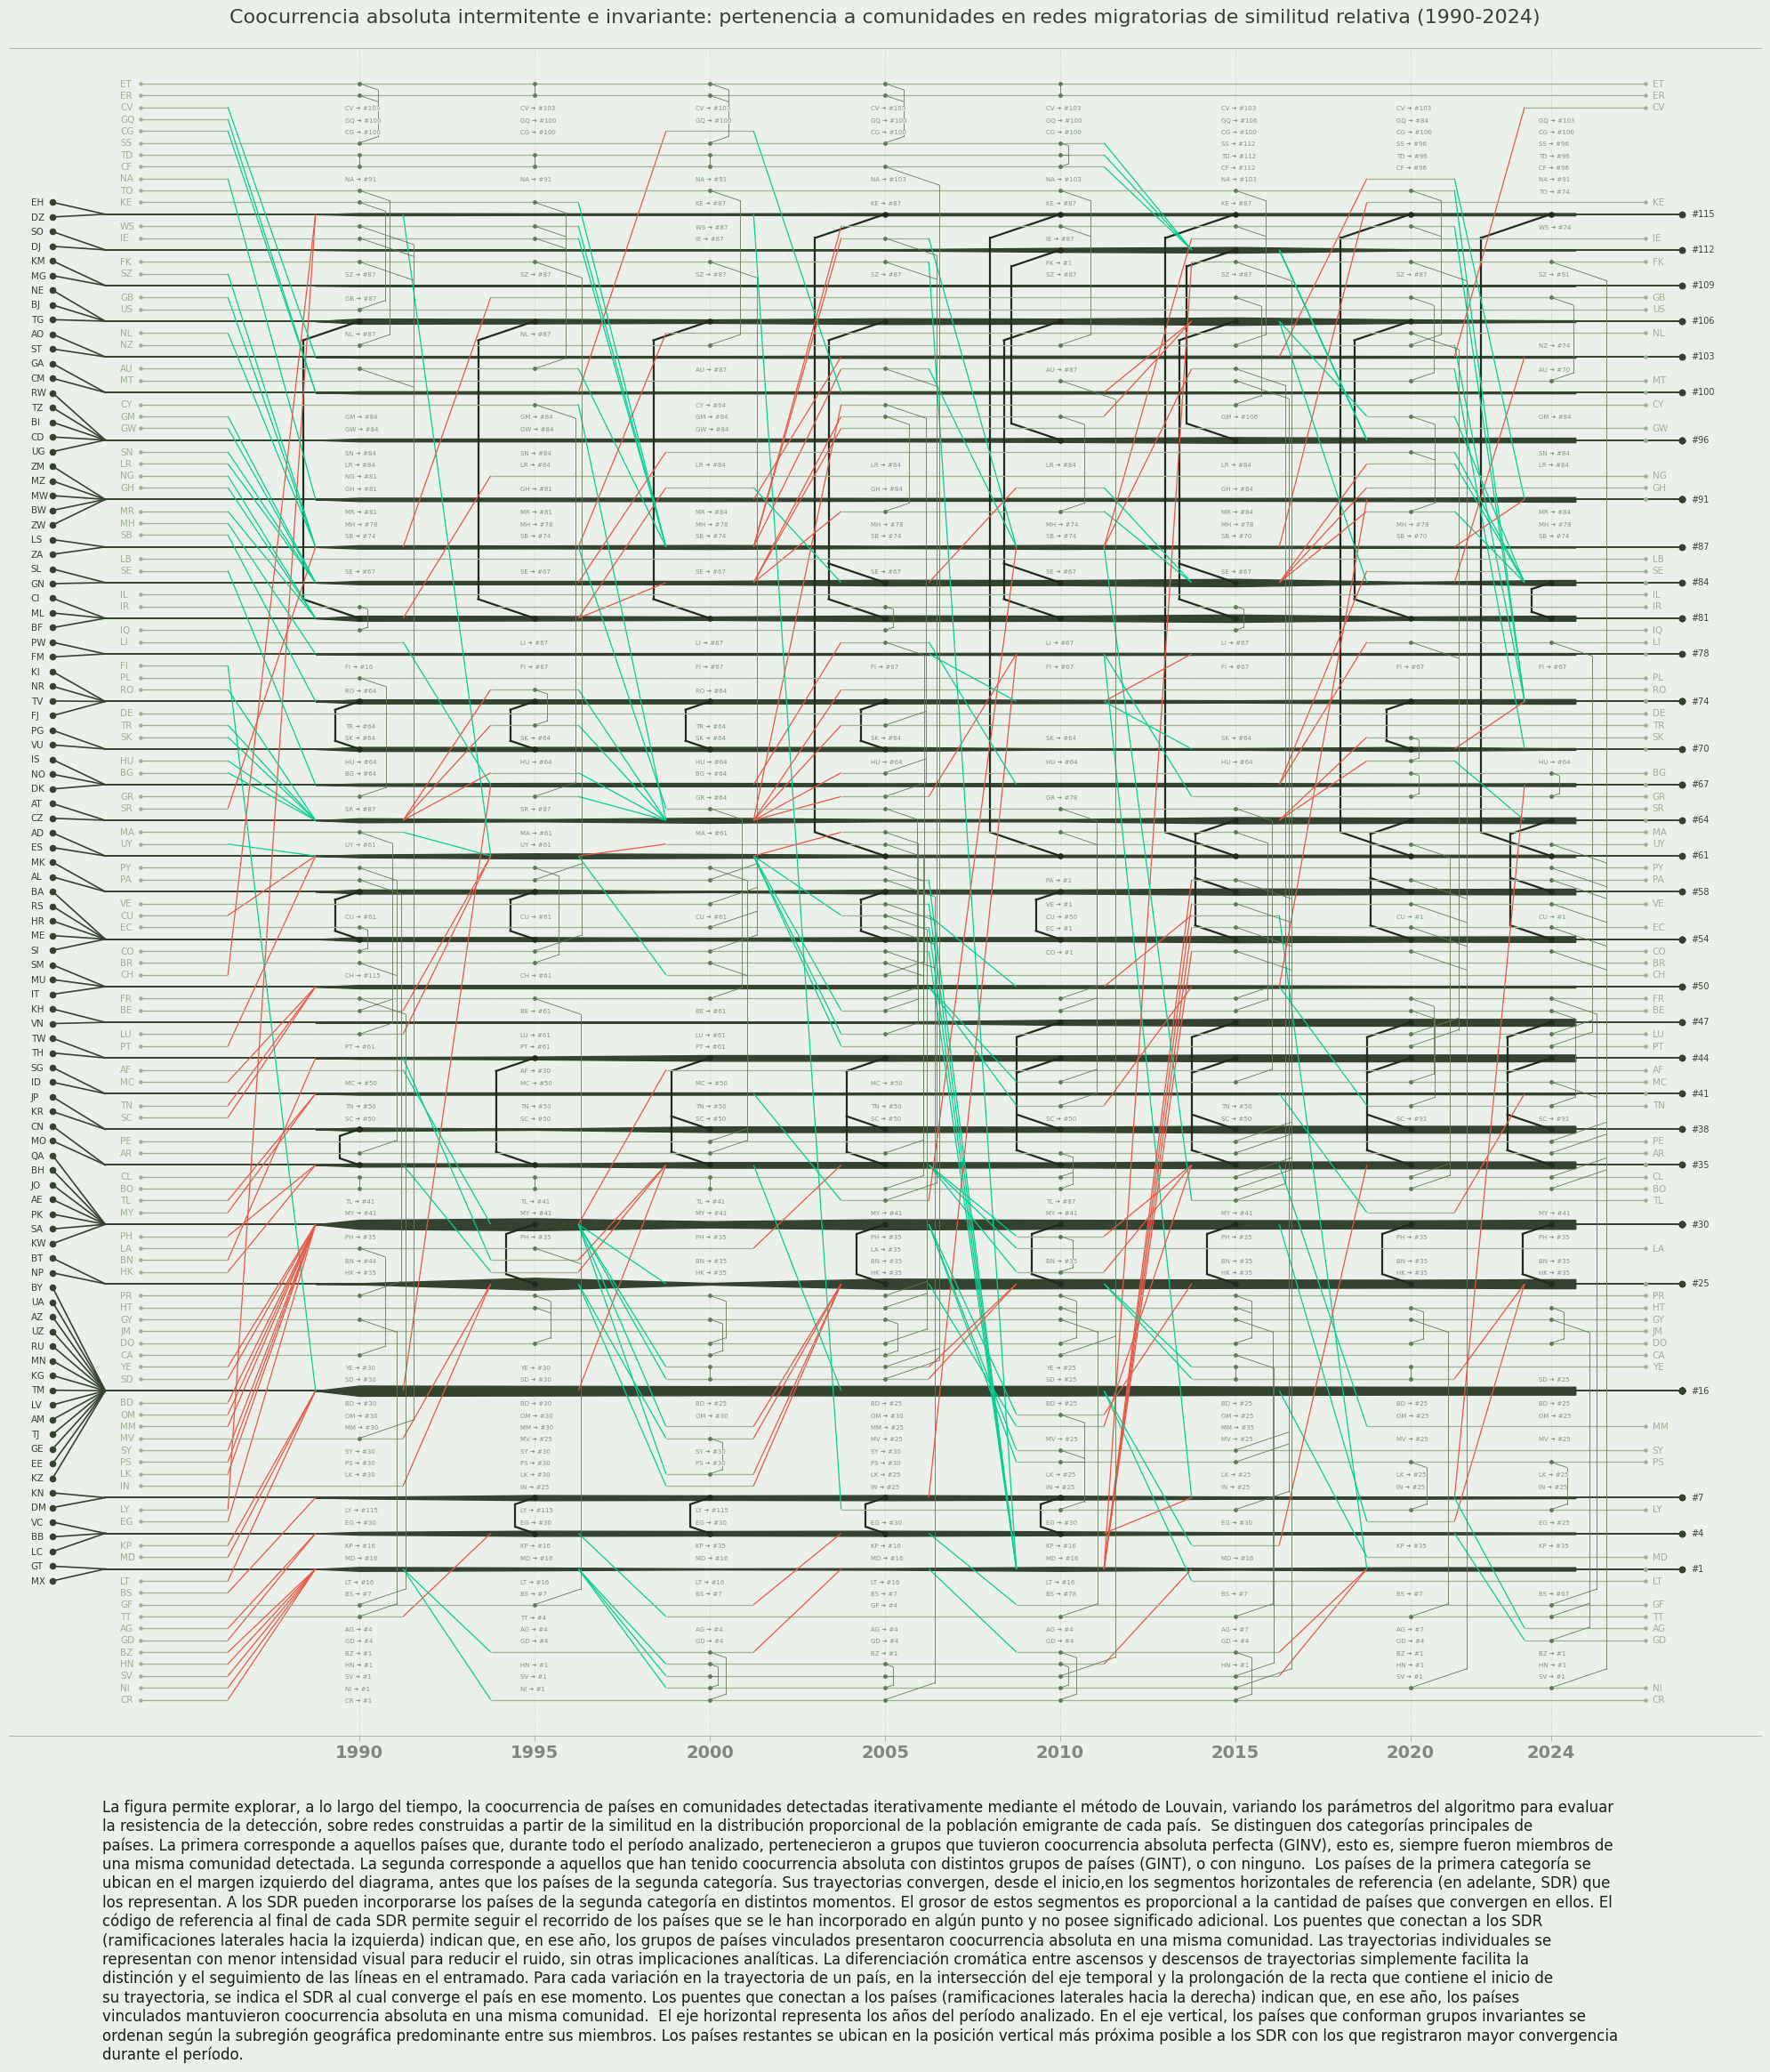

In [15]:
d_invariantes = dicc_ginv_sr.copy()
d_gint_por_año = dicc_gint_sr_por_año.copy()
d_cooc_por_año = dicc_cooc_sr_por_año.copy()

titulo = (
    'Coocurrencia absoluta intermitente e invariante: '
    'pertenencia a comunidades en redes migratorias de similitud relativa (1990-2024)'
)
nombre_salida = 'diagrama_trayectorias_similitud_relativa'

descripcion = (
'La figura permite explorar, a lo largo del tiempo, la coocurrencia de países '
'en comunidades detectadas iterativamente mediante el método de Louvain, '
'variando los parámetros del algoritmo para evaluar la resistencia de la detección, '
'sobre redes construidas a partir de la similitud en la distribución proporcional '
'de la población emigrante de cada país.\n'
'\nSe distinguen dos categorías principales de países. La primera corresponde a aquellos '
'países que, durante todo el período analizado, pertenecieron a grupos que tuvieron '
'coocurrencia absoluta perfecta (GINV), esto es, siempre fueron miembros de una misma comunidad '
'detectada. La segunda corresponde a aquellos que han tenido coocurrencia absoluta con '
'distintos grupos de países (GINT), o con ninguno.\n'
'\nLos países de la primera categoría se ubican en el margen izquierdo del diagrama, '
'antes que los países de la segunda categoría. Sus trayectorias convergen, desde el inicio,'
'en los segmentos horizontales de referencia (en adelante, SDR) que los representan. '
'A los SDR pueden incorporarse los países de la segunda categoría en distintos momentos. '
'El grosor de estos segmentos es proporcional a la cantidad de países que convergen en ellos. '
'El código de referencia al final de cada SDR permite seguir el recorrido de los países '
'que se le han incorporado en algún punto y no posee significado adicional. Los puentes '
'que conectan a los SDR (ramificaciones laterales hacia la izquierda) indican que, en ese año, '
'los grupos de países vinculados presentaron coocurrencia absoluta en una misma comunidad. '
'Las trayectorias individuales se representan con menor intensidad visual para reducir el ruido, '
'sin otras implicaciones analíticas. La diferenciación cromática entre ascensos y descensos '
'de trayectorias simplemente facilita la distinción y el seguimiento de las líneas en el entramado. '
'Para cada variación en la trayectoria de un país, en la intersección del eje temporal '
'y la prolongación de la recta que contiene el inicio de su trayectoria, se indica el SDR '
'al cual converge el país en ese momento. Los puentes que conectan a los países (ramificaciones laterales '
'hacia la derecha) indican que, en ese año, los países vinculados mantuvieron coocurrencia absoluta en una misma comunidad. '    
'\nEl eje horizontal representa los años del período analizado. En el eje vertical, los países '
'que conforman grupos invariantes se ordenan según la subregión geográfica predominante '
'entre sus miembros. Los países restantes se ubican en la posición vertical más próxima '
'posible a los SDR con los que registraron mayor convergencia durante el período.'
)

pct_barra = 0.0
formato_barra: str = "{desc}: [{bar}] {percentage:3.0f}% | {elapsed}"
texto_barra: str = 'Construyendo diagrama de trayectorias'          
with tqdm(total=100, desc=texto_barra, bar_format=formato_barra) as barra_pct:
    vis = fa.crear_diagrama_de_trayectorias(
        LISTA_PAISES,
        d_invariantes,
        d_gint_por_año,
        d_cooc_por_año,
        titulo,
        descripcion,
        nombre_salida,
        barra_pct,
    )
display(vis[0])

## **Promedio de coocurrencias**

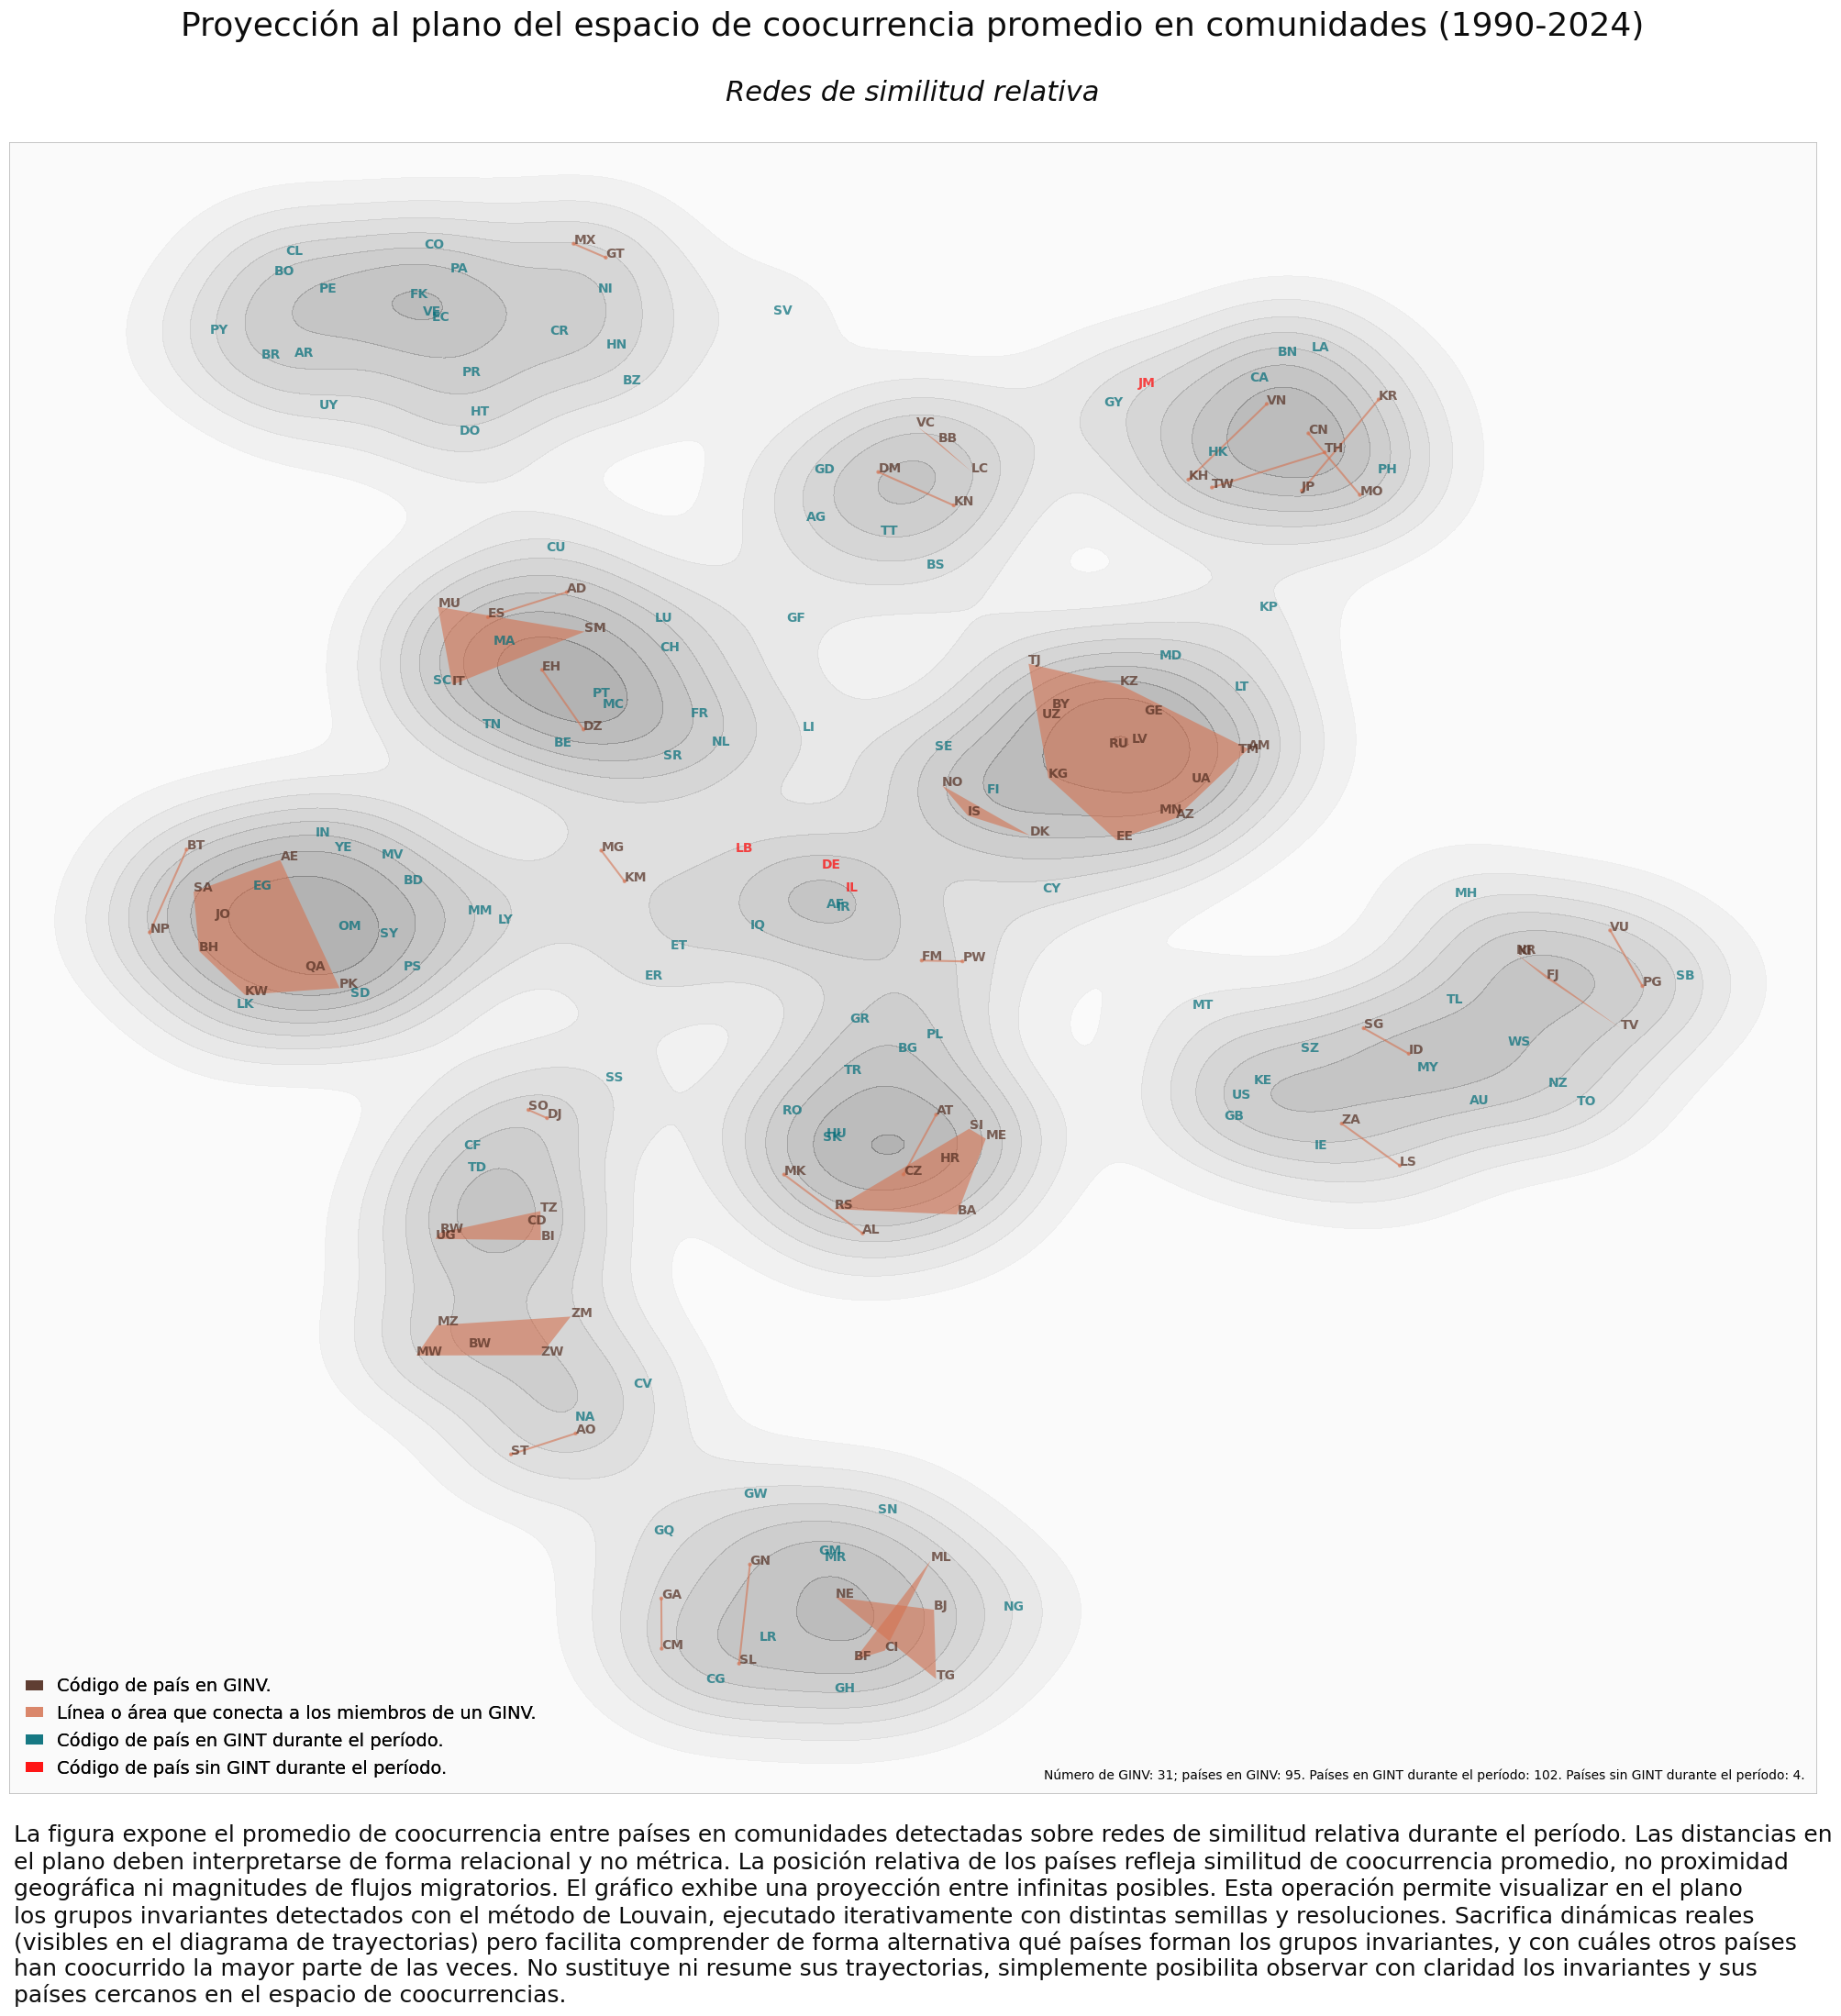

In [16]:
df_coocs_promedio = dicc_cooc_sr_por_año[1990].copy()
for año in AÑOS[1:]:
    df_coocs_promedio += dicc_cooc_sr_por_año[año]
df_coocs_promedio /= len(AÑOS)

# Indicamos que cada país mire a todos los restantes
vecinos_cercanos = len(LISTA_PAISES) - 1 
hiperparams = {
    'init': 'spectral',
    'n_components': 2,
    'n_neighbors': vecinos_cercanos,
    'min_dist': 1.0,
    'spread': 1.0,
    'metric': 'cosine',   
    'angular_rp_forest': True,
    'random_state': 42,
    'n_jobs': 1,
    'n_epochs': 500,
    'learning_rate': 1.0,
    'local_connectivity': 9, # Promedio de destinos (+2) que explican el 90% de las emigraciones de cada país
    'unique': False,
}
proyector = umap.UMAP(**hiperparams)        
incrustacion = proyector.fit_transform(df_coocs_promedio)
df_incrustacion = pd.DataFrame(
    incrustacion,
    columns=['x', 'y']
)
# Agregamos el país al cual corresponde las coordenadas
df_incrustacion['iso2'] = df_coocs_promedio.index.to_numpy()

# Visualizamos
titulo = 'Proyección al plano del espacio de coocurrencia promedio en comunidades (1990-2024)'
subtitulo = 'Redes de similitud relativa'
aclaracion = (
    'La figura expone el promedio de coocurrencia entre países en comunidades detectadas sobre redes de similitud '
    'relativa durante el período. '
    'Las distancias en el plano deben interpretarse de forma relacional y no métrica. '
    'La posición relativa de los países refleja similitud de coocurrencia promedio, no proximidad geográfica ni '
    'magnitudes de flujos migratorios. '
    'El gráfico exhibe una proyección entre infinitas posibles. Esta operación permite visualizar en el plano los grupos invariantes '
    'detectados con el método de Louvain, ejecutado iterativamente con distintas semillas y resoluciones. '
    'Sacrifica dinámicas reales (visibles en el diagrama de trayectorias) pero facilita comprender de forma alternativa '
    'qué países forman los grupos invariantes, y con cuáles otros países han coocurrido la mayor parte de las veces. '
    'No sustituye ni resume sus trayectorias, simplemente posibilita observar con claridad los invariantes y sus países ' 
    'cercanos en el espacio de coocurrencias.'
)

vis = fa.graficar_coocurrencia_en_plano(
    dicc_ginv_sr,
    df_incrustacion,
    LISTA_PAISES,
    paises_sin_gint,
    titulo,
    subtitulo,
    aclaracion,
    155,    
)
display(vis[0])

# **Principales comunidades de inmigrantes por país**

En esta sección, para cada país con datos migratorios exhibimos sobre el mapa cuáles fueron sus principales comunidades de inmigrantes durante el período. Los datos migratorios que no están desglosados por origen, los notamos con el código alfa-2 disponible **ZZ**, como recomienda el ISO 3166-1.

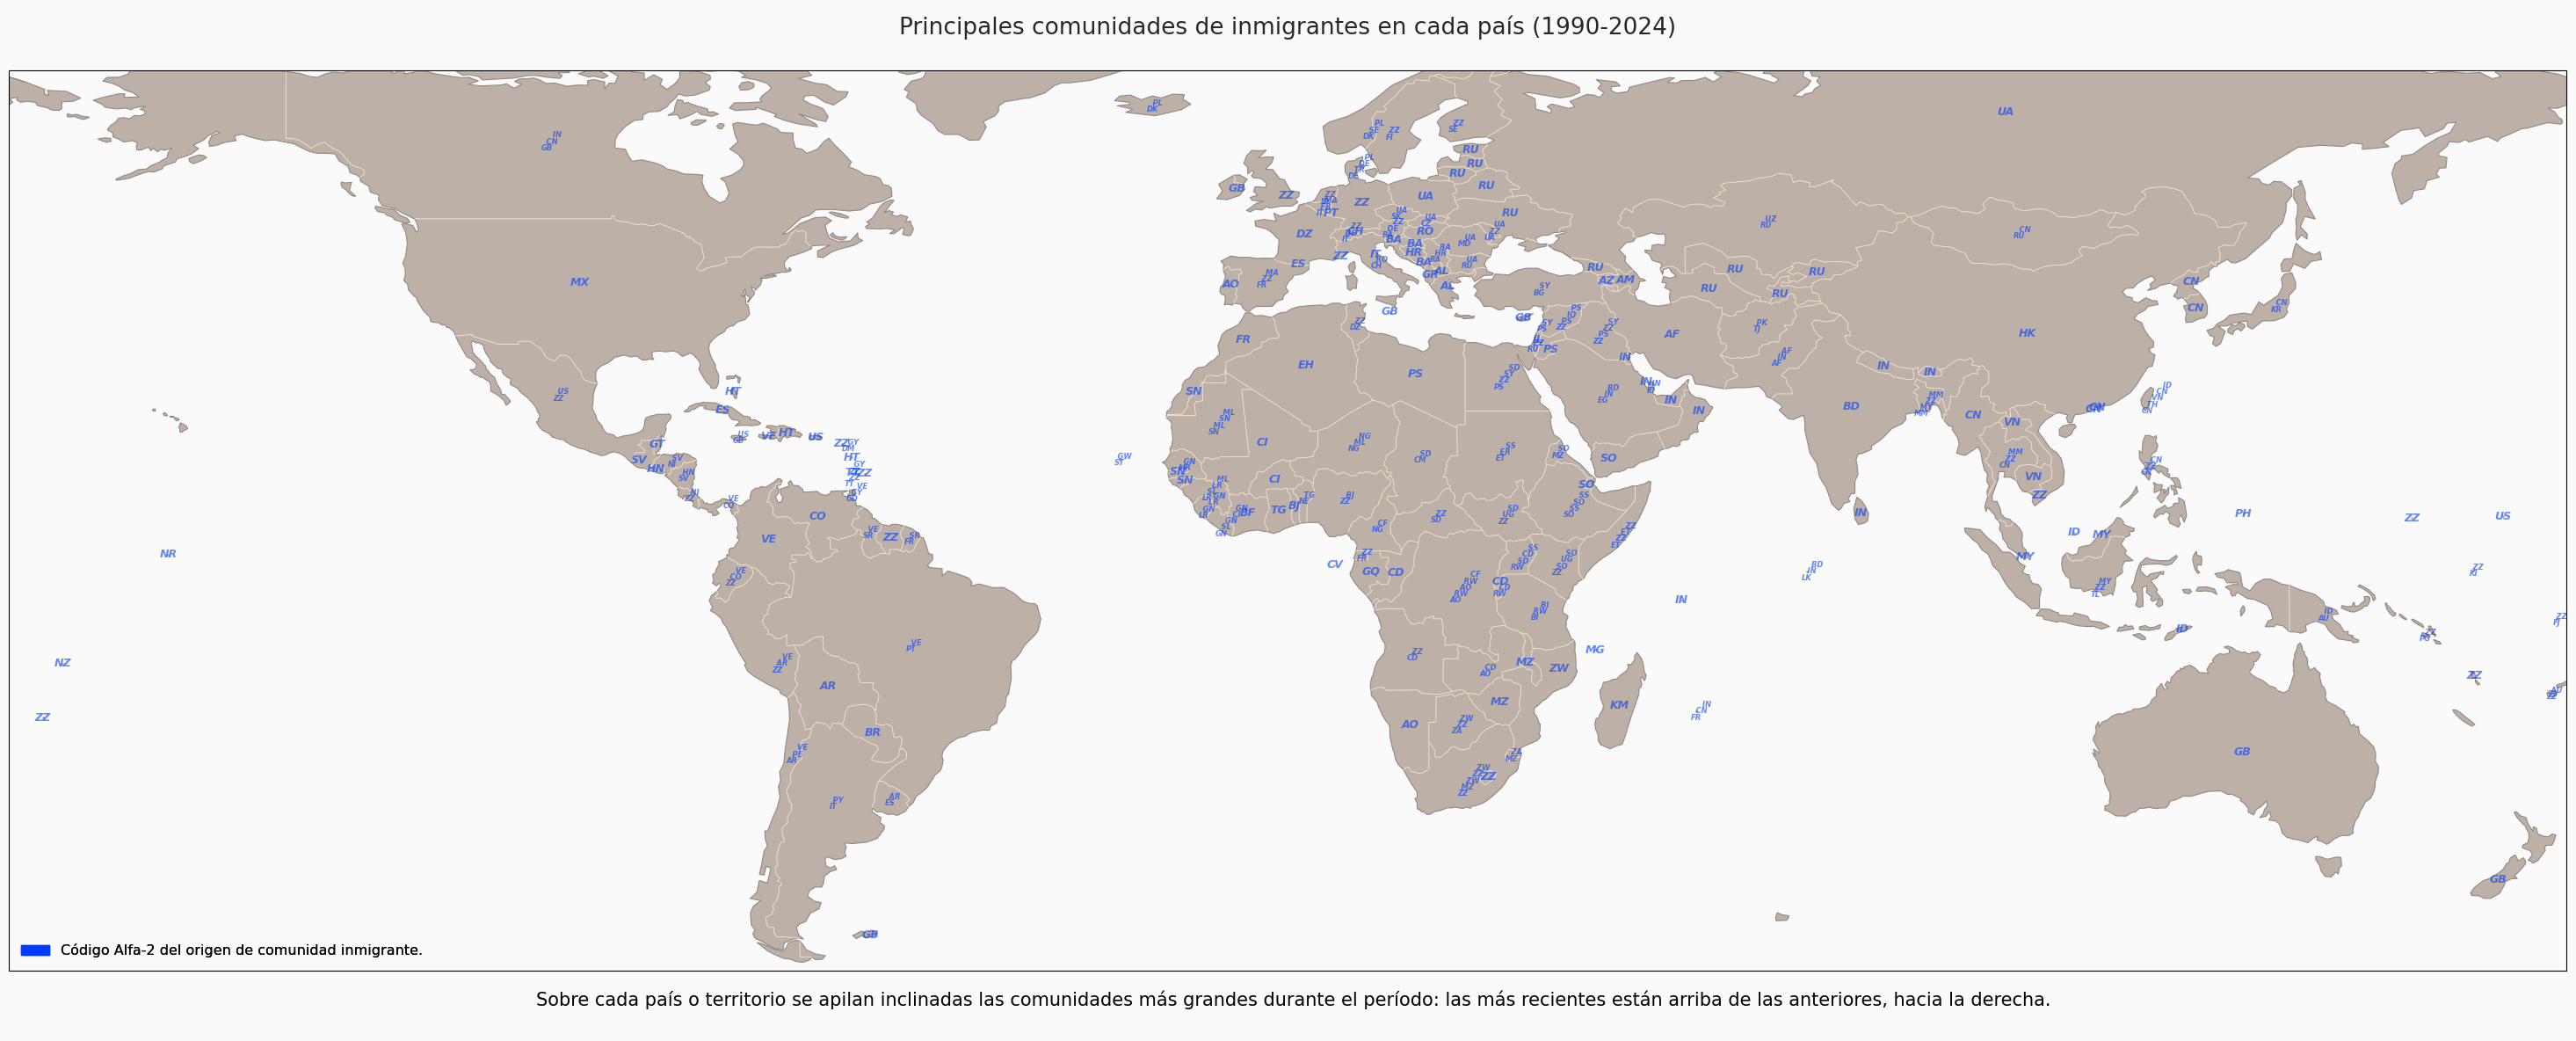

In [23]:
df_paises = (
    cdd.df_m49.merge(
        cdd.df_coordenadas,
        left_on=['iso3_m49'],
        right_on=['iso3_coord'],
        how='left'
    )
).drop(columns=['iso3_m49', 'iso3_coord'])

# Para cada año construimos un df donde cada fila contiene:
# iso2 del pais, lon, lat, iso2 de la comunidad mayoritaria de inmigrantes, cantidad de inmigrantes

# Para ordenar las tablas
columnas_ordenadas = ['cod_m49', 'iso2_m49', 'lon', 'lat']
columnas_a_descartar = ['año', 'origen_ES', 'origen_EN', 'destino_ES', 'destino_EN']

# Estructura que almacena los df con las comunidades de inmigrantes por país
dicc_comu_migrantes: dict[int, pd.DataFrame] = {}

for año in AÑOS:
    
    df_pobla_exterior = df_paises.copy()

    # Construimos el df con los datos de migraciones de cada país
    df_comun_inmig = pd.DataFrame()
    df_migras = (
        cdd.df_migraciones[cdd.df_migraciones.año == año].reset_index(drop=True)
    )
    for cod_pais in df_paises.cod_m49.unique():
        # 'Otros' no existe como país, solo como magnitud sin orígen
        if cod_pais == 2003:
            continue
        # Nos quedamos con las comunidades de migrantes en el país
        df_pais = (
            df_migras[df_migras.cod_des == cod_pais]
            .drop(columns=columnas_a_descartar)
        ).sort_values(['migrantes'], ascending=False)
    
        if len(df_pais) != 0:
            # Nos quedamos con la comunidad inmigrante más grande
            pobla_mayor = df_pais.iloc[[0]].reset_index(drop=True)
            df_comun_inmig = pd.concat([df_comun_inmig, pobla_mayor])    
    df_comun_inmig.reset_index(drop=True)

    # Unimos las columnas a la tabla de poblaciones exteriores
    df_pobla_exterior = (
        df_pobla_exterior.merge(
            df_comun_inmig,
            left_on='cod_m49',
            right_on='cod_des',
            how='left',
        ).drop(columns=['cod_des'])
    # Asociamos cada país destino con el país origen de la comunidad inmigrante más grande
    ).rename(columns={'cod_orig':'cod_inmig', 'migrantes':'inmigrantes'})

    # Agregamos los codigos de país de las comunidades inmigrantes
    df_codigos_coord = (
        df_pobla_exterior[['cod_m49', 'iso2_m49']]
        .rename(columns={'cod_m49':'cod_temp', 'iso2_m49':'iso2_inmig'})
    )
    df_pobla_exterior = (
        df_pobla_exterior.merge(
            df_codigos_coord,
            left_on='cod_inmig',
            right_on='cod_temp',
            how='left'
        )
    ).sort_values(['iso2_m49'], ascending=True).reset_index(drop=True) 

    # Ordenamos la tabla
    columnas_ordenadas_final = [
        'iso2_m49',
        'lon',
        'lat',
        'inmigrantes',
        'iso2_inmig',    
    ]
    df_pobla_exterior = df_pobla_exterior[columnas_ordenadas_final]
    dicc_comu_migrantes[año] = df_pobla_exterior

# Obtenemos la lista de comunidades principales de cada país a través del período
lista_paises_y_otros = cdd.df_migras_90_24.iso2_orig.unique().tolist() 
dicc_comu_por_pais = {}
for pais in lista_paises_y_otros:
    # 'Otros' no existe como país, solo como magnitud sin orígen
    if pais == 'ZZ': 
        continue
    lista_comu_inmig = []
    for año in AÑOS:
        lista_comu_inmig.append(
            dicc_comu_migrantes[año].loc[
                dicc_comu_migrantes[año].iso2_m49 == pais, 'iso2_inmig'
            ].iloc[0]
        )
    dicc_comu_por_pais[pais] = lista_comu_inmig

# Invertimos el orden (primero las comunidades más recientes) y eliminamos duplicados
dicc_comu_para_grafo = {}
for pais, comunidades in dicc_comu_por_pais.items():
    lista_comunidades = []
    comunidades_ordenadas = comunidades[::-1]
    for i in range(len(comunidades_ordenadas)):
        comunidad = comunidades_ordenadas[i]
        if i == 0:
            lista_comunidades.append(comunidad) 
        else:
            if comunidad != lista_comunidades[-1]:
                lista_comunidades.append(comunidad)    
    dicc_comu_para_grafo[pais] = lista_comunidades
    
# Preparamos las etiquetas
dicc_etiquetas = {}
for pais, comunidades in dicc_comu_para_grafo.items():
    etiqueta = ''
    i = 1
    for comu_inmig in comunidades:
        etiqueta += '    ' * (len(comunidades) - i)
        etiqueta += f'{comu_inmig}\n'
        i += 1
    dicc_etiquetas[pais] = etiqueta[:-1]



# Visualizamos
grafo_pobla_ext = nx.DiGraph()

# Agregamos los nodos
for i in range(df_paises.shape[0]):
    # Obtengo la fila a ingresar 
    fila = df_paises.iloc[i]
    # Obtengo los iso2 del país
    pais = fila.iloc[1]
    if pais == 'ZZ':
        continue
    # Coordenadas del centroide
    x_pais, y_pais = fila.iloc[12], fila.iloc[13]

    grafo_pobla_ext.add_node(
        pais,
        pos=(x_pais, y_pais),
        weight=10,
        etiqueta=dicc_etiquetas[pais] 
    )


titulo = "Principales comunidades de inmigrantes en cada país (1990-2024)"
nota_al_pie = (
    'Sobre cada país o territorio se apilan inclinadas las comunidades más grandes durante el período: '
    'las más recientes están arriba de las anteriores, hacia la derecha. '
)
vis = fa.graficar_comunidades_ppales(
    grafo_pobla_ext,
    titulo,
    nota_al_pie    
)
display(vis)
